In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
sns.set_style('white')
sns.set_context('talk')
import numpy as np
import pandas as pd
import addict
from tqdm import tqdm
import scipy.integrate
import csv
import datetime

font_size=35
sns.set_style('white')
sns.set_context("talk", font_scale=1.0, rc={'lines.linewidth': 10,
                                             'axes.linewidth': 3,
                                             'font.size': font_size,
                                             'axes.labelsize': font_size,
                                             'xtick.labelsize': font_size,
                                             'ytick.labelsize': font_size,
                                             'legend.fontsize': font_size,
                                             'text.usetex': True,
                                             'font.family': 'sans-serif',
                                            'axes.axisbelow': True,
})
log_dict = addict.Dict()

In [2]:

#bound_k = 32
def parse_hvm_log(log_file):
  df = pd.read_csv(log_file)
  # df = df.set_index('step')[['importance-bound-free-energy', 'k',
  #                            'compute_time']].dropna()
  # df = df[df['k'] == bound_k]
  df = df.set_index('step')[['importance-sampling-free-energy',
                             'compute_time']].dropna()
  df = df[df.index >= 1]

  df['used_time'] = df.compute_time.cumsum()  
  df['F'] = df['importance-sampling-free-energy']
  return df


def parse_hvm_dir(hvm_dir):
  hvm_dir = pathlib.Path(hvm_dir)
  log_dict = addict.Dict()
  for f in hvm_dir.rglob('*.csv'):
    name = str(f.parts[-2])
    split = name.split('_')  
    if 'sk' in str(f):
      model = 'sk'
      L = int(name.lstrip('num_spins=').split('_')[0])    
    else:
      model = 'ising'
      L = int(name.lstrip('lattice_length=').split('_')[0])    
    beta = float(name.split('beta=')[1])
    log_dict[model]['hvm'][L][beta] = parse_hvm_log(f)
  return log_dict
        

def ising_exact_free_energy(beta, J_horizontal, J_vertical):
  """Calculate exact free energy per site.

  https://en.wikipedia.org/wiki/Square-lattice_Ising_model
  """
  K = beta * J_horizontal
  L = beta * J_vertical
  cosh2Kcosh2L = np.cosh(2 * K) * np.cosh(2 * L)
  k = 1 / (np.sinh(2 * K) * np.sinh(2 * L))
  def theta_integrand(theta):
    """Integrand in expression for free energy of square lattice."""
    return np.log(cosh2Kcosh2L +
                  1 / k * np.sqrt(1 + k ** 2 - 2 * k * np.cos(2 * theta)))
  integral, _ = scipy.integrate.quad(theta_integrand, 0, np.pi)
  F = np.log(2) / 2 + 1 / (2 * np.pi) * integral
  return -F / beta

In [3]:
ising_exact_free_energy(0.4, 1, 1)

-2.198409551937284

In [4]:
hvm_dir = '/Users/jaan/log/transfer_tigergpu/vi-for-physics/2019-09-11/'
hvm_log_dict_long = parse_hvm_dir(hvm_dir)
hvm_dir = '/Users/jaan/log/transfer_tigergpu/vi-for-physics/2019-09-09/'
hvm_log_dict_short = parse_hvm_dir(hvm_dir)
for model in ['sk', 'ising']:
  sizes = hvm_log_dict_short[model]['hvm'].keys()
  for size in sizes:
    betas = hvm_log_dict_long[model]['hvm'][size].keys()
    for beta in betas:
      df1 = hvm_log_dict_short[model]['hvm'][size][beta]
      df2 = hvm_log_dict_long[model]['hvm'][size][beta]
      log_dict[model]['hvm'][size][beta] = pd.concat([df1, df2]).sort_index()

In [5]:
# for N=16384. or use 09-11
log_dict.update(parse_hvm_dir('/Users/jaan/log/transfer_tigergpu/vi-for-physics/2019-09-13/sk-larger-128'))

In [6]:
def parse_hvm_json(json_file):
  df = pd.read_json(json_file)
  df.columns = ['time', 'step', 'F']
  df['used_time'] = df.time - df.time[0]
  return df

In [7]:
log_dict['ising']['hvm'][1048576][0.4] = parse_hvm_json('/Users/jaan/log/transfer_tigergpu/vi-for-physics/2020-02-16/run-num_spins=1048576_control_variate=False_rao_blackwellize=True_hidden_size=8-tag-free_energy_importance_bound_k8.json')
log_dict['sk']['hvm'][16384][0.4] = parse_hvm_json('/Users/jaan/Downloads/run-sk-realnvp_full_conditioning-conv-perm_num_spins=16384-tag-free_energy_importance_bound_k8.json')
log_dict['sk']['hvm'][4096][0.4] = parse_hvm_json('/Users/jaan/Downloads/run-sk-realnvp_full_conditioning-conv-perm_num_spins=4096-tag-free_energy_importance_bound_k8.json')
log_dict['ising']['hvm'][4096][0.4] = parse_hvm_json('/Users/jaan/Downloads/run-realnvp_full_conditioning-conv-perm_num_spins=4096-tag-free_energy_importance_bound_k8.json')

In [8]:
def parse_van_log(log_file):
  df = pd.DataFrame({})
  dict_list = []
  with log_file.open('r') as f:
    for _ in range(56):
      next(f)
    reader = csv.reader(f, delimiter=',')
    for row in reader:
      if 'sk' in str(log_file):
        row.pop(1)
      key_value_pairs = [col.strip().split(' = ') for col in row]
      dict_list.append(dict(key_value_pairs))
  return pd.DataFrame(dict_list, dtype=float)

In [9]:
def parse_van_dir(van_dir):
  van_dir = pathlib.Path(van_dir)
  for f in tqdm(van_dir.rglob('out.log')):
    print(f)
    name = f.parts[-3]
    if 'sk' in str(f):
      model = 'sk'
      system_size = int(name.split('n')[1].split('_')[0])
    else:
      model = 'ising'
      system_size = int(name.split('L')[1][:2])
    beta = float(name.split('beta')[1])
    log_dict[model]['van'][system_size][beta] = parse_van_log(f)

In [10]:
van_dir = pathlib.Path('/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10')
parse_van_dir(van_dir)

3it [00:00, 27.08it/s]

/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n2048_beta0.7/nd1_nw1_made_z2_ba1.5_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n4096_beta0.7/nd1_nw1_made_z2_ba1.5_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L64_beta0.4/nd3_nw64_hks6_bias_z2_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L16_beta0.4/nd3_nw64_hks6_bias_z2_cg1/out.log


4it [00:00, 17.82it/s]

/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L32_beta0.4/nd3_nw64_hks6_bias_z2_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n20_beta0.4/nd1_nw1_made_z2_ba1.5_cg1/out.log


7it [00:38,  4.09s/it]

/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n2048_beta0.4/nd1_nw1_made_z2_ba1.5_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n4096_beta0.4/nd1_nw1_made_z2_ba1.5_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L64_beta0.7/nd3_nw64_hks6_bias_z2_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L16_beta0.7/nd3_nw64_hks6_bias_z2_cg1/out.log


10it [00:38,  2.87s/it]

/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/fm_sqr_periodic_L32_beta0.7/nd3_nw64_hks6_bias_z2_cg1/out.log
/Users/jaan/log/transfer_tigergpu/stat-mech-van/2019-09-10/sk_n20_beta0.7/nd1_nw1_made_z2_ba1.5_cg1/out.log


12it [01:12,  6.05s/it]


In [11]:
log_dict['ising']['van'][64][0.4].F.min()

-2.0674298

In [13]:
log_dict['ising']['hvm'][1048576]

{0.4:             time   step         F     used_time
 0   1.581636e+09      0  3.645917      0.000000
 1   1.581637e+09    500 -1.922454    779.344395
 2   1.581638e+09   1000 -2.047155   1558.700146
 3   1.581638e+09   1500 -2.083135   2338.048571
 4   1.581639e+09   2000 -2.094574   3117.375905
 5   1.581640e+09   2500 -2.100034   3896.700332
 6   1.581641e+09   3000 -2.101707   4676.033013
 7   1.581642e+09   3500 -2.104299   5455.357840
 8   1.581642e+09   4000 -2.105548   6234.914716
 9   1.581643e+09   4500 -2.106824   7014.576321
 10  1.581644e+09   5000 -2.107903   7794.245696
 11  1.581645e+09   5500 -2.108382   8573.906683
 12  1.581645e+09   6000 -2.108866   9353.565256
 13  1.581646e+09   6500 -2.109449  10133.221817
 14  1.581647e+09   7000 -2.110270  10912.888929
 15  1.581648e+09   7500 -2.110243  11692.554050
 16  1.581649e+09   8000 -2.110978  12472.222695
 17  1.581649e+09   8500 -2.110769  13251.893691
 18  1.581650e+09   9000 -2.111612  14031.557191
 19  1.581651e+

In [14]:
log_dict['sk']['hvm'][4096][0.4].F.min()

-1.748996973037719

In [15]:
log_dict['ising']['van'].keys(), log_dict['ising']['hvm'].keys()

(dict_keys([64, 16, 32]), dict_keys([32, 64, 16, 1048576, 4096]))

In [16]:
log_dict['sk']['van'].keys(), log_dict['sk']['hvm'].keys()

(dict_keys([2048, 4096, 20]), dict_keys([20, 2048, 4096, 16384]))

In [49]:
sns.palettes.xkcd_rgb

{'acid green': '#8ffe09',
 'adobe': '#bd6c48',
 'algae': '#54ac68',
 'algae green': '#21c36f',
 'almost black': '#070d0d',
 'amber': '#feb308',
 'amethyst': '#9b5fc0',
 'apple': '#6ecb3c',
 'apple green': '#76cd26',
 'apricot': '#ffb16d',
 'aqua': '#13eac9',
 'aqua blue': '#02d8e9',
 'aqua green': '#12e193',
 'aqua marine': '#2ee8bb',
 'aquamarine': '#04d8b2',
 'army green': '#4b5d16',
 'asparagus': '#77ab56',
 'aubergine': '#3d0734',
 'auburn': '#9a3001',
 'avocado': '#90b134',
 'avocado green': '#87a922',
 'azul': '#1d5dec',
 'azure': '#069af3',
 'baby blue': '#a2cffe',
 'baby green': '#8cff9e',
 'baby pink': '#ffb7ce',
 'baby poo': '#ab9004',
 'baby poop': '#937c00',
 'baby poop green': '#8f9805',
 'baby puke green': '#b6c406',
 'baby purple': '#ca9bf7',
 'baby shit brown': '#ad900d',
 'baby shit green': '#889717',
 'banana': '#ffff7e',
 'banana yellow': '#fafe4b',
 'barbie pink': '#fe46a5',
 'barf green': '#94ac02',
 'barney': '#ac1db8',
 'barney purple': '#a00498',
 'battleship gr

In [6]:
today = datetime.date.today().strftime('%Y-%m-%d')
# out_dir = pathlib.Path(f'/Users/jaan/log/transfer_tigergpu/{today}/fig')
# if not out_dir.exists():
#   out_dir.mkdir()
labels = {'van': 'VAN', 'hvm': 'HVM'}
linestyle = {'van': '-', 'hvm': '-'}
palettes = {'van': sns.xkcd_palette(['amber', 'bile']),
            'hvm': sns.xkcd_palette(['bubblegum', 'barney purple'])}

# palettes = {'van': sns.light_palette('orange', reverse=True, n_colors=5),
#             'hvm': sns.light_palette('blue', reverse=True, n_colors=5)}
ylim = {'sk': {0.4: [-1.85, -1.5], 0.7: [-1.20, -0.85]},
        'ising': {0.4: [-2.25, -1.5], 0.7: [-2.2, -1.5]}}
# colors = {'sk': {32: }}

plot_sizes = {'ising': {'van': [32, 64],
                        'hvm': [32, 1048576]},
              'sk': {'van': [4096],
                        'hvm': [4096, 16384]}
             }
    
# ylim = {0.4: [-1.85, -1.5], 0.7: [-1.20, -0.85]}
# plot BOTH or only one
for model in ['sk', 'ising']:
#   L = list(log_dict[model]['hvm'].keys())[0]
#   for beta in log_dict[model]['hvm'][L].keys():
  for beta in [0.4]:
    fig, ax = plt.subplots(figsize=(5 * 1.618, 5))
    if model == 'ising':
      ax.axhline(y=ising_exact_free_energy(beta, 1, 1), label='Exact',
                 color='gray',
                 linestyle='--')
    for method in ['van', 'hvm']:
      sizes = sorted(log_dict[model][method].keys())
      sizes = [size for size in sizes if size in plot_sizes[model][method]]
      for i, L in enumerate(sizes):
        print(model, method, L, beta)
        df = log_dict[model][method][L][beta]
        df = df[df.used_time.values / 60 / 60 < 6]
        if model == 'ising':
          label = f'{labels[method]} L={L}'
        elif model == 'sk':
          label = f'{labels[method]} N={L}'
        ax.plot(df.used_time.values / 60 / 60,
                df.F.values,
                label=label,
                color=palettes[method][i],
        linestyle=linestyle[method],
        #linewidth=8
        )
        # if method == 'hvm':
        #   last = df.tail(1)
        #   time_every_log = (6 * 60 * 60 - last.used_time.item()) / (last.index[0] / 1000) / 60
        #   print(last.index[0], last.F.item(), 1 / (last.compute_time.item() /
        #                                            1000),
        #         'time used for importance sampling:', (6 * 60 * 60 -
        #                                                last.used_time.item()),
        #         'time used every 1000 iterations:', time_every_log,
        #         'log_interval', 6 * 60 * 60 / 10 * 1000 /
        #         last.compute_time.item(),
        #         'additional_time (hours)', time_every_log * 10 / 60)
        # else:
        #   print(df.tail(1))
          
    #ax.legend()
    ax.set_ylim(ylim[model][beta])
    ax.set(xlabel='Time (h)', ylabel='Free Energy',)
#            xscale='log')
    ax.set_xlim([-0.05, 6])
    ax.yaxis.grid()
    sns.despine(right=True, left=True)
    plt.savefig(f'/Users/jaan/fig/vi-for-physics/2019-09-16/{model}_free-energy-vs-time_beta={beta}_importance_sampling_final-van-only.pdf', bbox_inches='tight')
    plt.close()

sk hvm 4096 0.4
ising hvm 32 0.4


In [8]:
method

'hvm'

HVM, $N=1024$
HVM, $N=1048576$
VAN, $N=1024$
VAN, $N=4096$


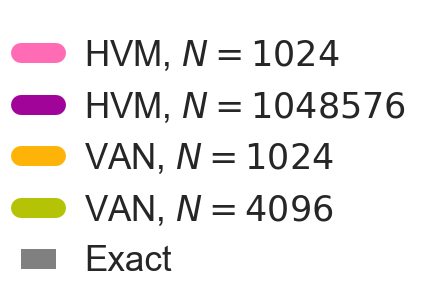

In [11]:
# Create legend handles manually
handles = []
for method in ['hvm', 'van']:
  i = 0
  for L in [1024, 4096, 1048576]:
    if L == 1048576 and method == 'van':
      pass
    elif L == 4096 and method == 'hvm':
      pass
    else:
      label = f'{labels[method]}, $N={L}$'
      print(label)
      handles.append(mpl.lines.Line2D([0], [0], color=palettes[method][i], lw=20, label=label))
      i += 1
handles.append(mpl.lines.Line2D([0], [0], color='gray', lw=20, label='Exact', linestyle='--'))

# Create legend
plt.legend(handles=handles, handlelength=1, frameon=False)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.tight_layout()
fig.subplots_adjust(bottom=0.5, hspace=0.9)
plt.savefig('../../doc/ml4ps2019/fig/legend.pdf', bbox_inches='tight')

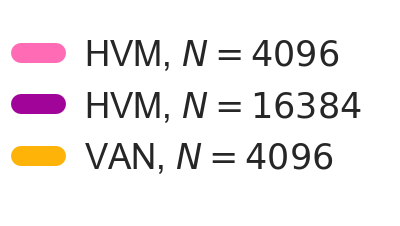

In [61]:
# Create legend handles manually
handles = []
for method in ['hvm', 'van']:
  for i, L in enumerate([4096, 16384]):
    if L == 16384 and method == 'van':
      pass
    else:
      label = f'{labels[method]}, $N={L}$'
      handles.append(mpl.lines.Line2D([0], [0], color=palettes[method][i], lw=20, label=label))
# Create legend
plt.legend(handles=handles, handlelength=1, frameon=False)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.tight_layout()
fig.subplots_adjust(bottom=0.5, hspace=0.9)
plt.savefig('../../doc/ml4ps2019/fig/legend-sk.pdf', bbox_inches='tight')